# Experiment Analysis: Controller parameter stability search
Perform shocks of ETH price to test controller parameter stability, without stochastic processes.

* See `experiments/system_model_v3/experiment_shocks.py`

# Setup and Dependencies

In [1]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

# Force reload of project modules, sometimes necessary for Jupyter kernel
%load_ext autoreload
%autoreload 2

# Display framework versions for easy debugging
%pip show cadCAD
%pip show radcad

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/georgekellerman/github/reflexer.bacl/venv/lib/python3.8/site-packages
Requires: pandas, fn, pathos, funcy
Required-by: cadCAD-machine-search
Note: you may need to restart the kernel to use updated packages.
Name: radcad
Version: 0.5.6
Summary: A cadCAD implementation, for dynamical systems modelling & simulation
Home-page: None
Author: Benjamin Scholtz
Author-email: ben@bitsofether.com
License: None
Location: /Users/georgekellerman/github/reflexer.bacl/venv/lib/python3.8/site-packages
Requires: boto3, ray, pandas, pathos, tables
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import all shared dependencies and setup
from shared import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 600
from pprint import pprint

In [3]:
# Update dataframe display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

# Load Results

Using the experiment logs, select the experiment of interest from the specific HDF5 store file (these datasets are very large, and won't be committed to repo):

In [4]:
experiment_results = 'experiments/system_model_v3/experiment_controller_sweep/experiment_results.hdf5'

In [5]:
experiment_results_keys = []
with pd.HDFStore(experiment_results) as store:
    experiment_results_keys = list(filter(lambda x: "results" in x, store.keys()))
    exceptions_keys = list(filter(lambda x: "exceptions" in x, store.keys()))

In [6]:
# A list of all experiment result keys
experiment_results_keys

['/processed_results_2021-03-29T22:19:22.699859',
 '/processed_results_2021-03-29T22:53:14.585998',
 '/processed_results_2021-03-29T23:03:25.746529',
 '/results_2021-03-29T22:19:22.699859',
 '/results_2021-03-29T22:53:14.585998',
 '/results_2021-03-29T23:03:25.746529',
 '/results_2021-03-29T23:05:47.088901']

In [7]:
# A list of all experiment result exception keys
#exceptions_keys

In [8]:
# Copy a results_ key from the above keys to select the experiment
res_ts = '2021-03-29T23:05:47.088901'
experiment_results_key = 'results_' + res_ts # Or select last result: experiment_results_keys[-1]
experiment_timestamp = experiment_results_key.strip('results_')
exceptions_key = 'exceptions_' + experiment_timestamp
experiment_timestamp

'2021-03-29T23:05:47.088901'

In [9]:
df_raw = pd.read_hdf(experiment_results, experiment_results_key)

Get experiment exceptions, tracebacks, and simulation metadata for further analysis:

# Post Process Results

In [10]:
from experiments.system_model_v3.post_process import post_process_results

from experiments.system_model_v3.experiment_controller_sweep import params
print(params['trader_market_premium'])
print(params['price_trader_bound'])
print(params['rate_trader_apy_bound'])

[1.05]
[0.2]
[60]


Remove substeps, add `set_params` to dataframe, and add post-processing columns:

In [11]:
df = post_process_results(df_raw, params, set_params=['kp', 'ki', 'kd', 'liquidation_ratio'])
#df

Adding new columns
0.018244266510009766
Getting parameter sweep
0.018380165100097656
Assigning parameters to subsets
0.2052140235900879
Creating target_price_scaled
0.2117292881011963


In [12]:
%%capture
# Save the processed results to the same HDF5 store file
df.to_hdf(experiment_results, key=f'processed_results_{experiment_timestamp}')

# Control Parameters

In [13]:
df_control_parameters = df[['subset', 'kp', 'ki', 'kd']]

df_control_parameters = df_control_parameters.drop_duplicates(subset=['kp', 'ki', 'kd'])
#df_control_parameters

# Simulation Analysis

Get the initial target price to test stability conditions:

In [14]:
initial_target_price = df['target_price'].iloc[0]
initial_target_price
df['apy'] = ((1 + df['target_rate']) ** (60*60*24*356) - 1) * 100

Find all controller constant subsets where the price goes to zero:

In [15]:
df_market_price_zero = df.query("market_price <= 0.1*@initial_target_price")
df_market_price_zero[['subset', 'kp', 'ki', 'kd']].drop_duplicates(subset=['kp', 'ki', 'kd'])

,subset,kp,ki,kd


Find all controller constant subsets where the price goes to infinity:

In [16]:
df_market_price_infinity = df.query("market_price > 10*@initial_target_price")
df_market_price_infinity[['subset', 'kp', 'ki', 'kd']].drop_duplicates(subset=['kp', 'ki', 'kd'])

,subset,kp,ki,kd


Create dataframe of stable simulation scenarios.

Stability is defined as:
1. The market price and scaled target price remaining within 0.1x and 10x the starting price, for all timesteps

In [17]:
initial_target_price = df['target_price'].iloc[0]
initial_eth_price = df['eth_price'].iloc[0]
last_timestep = df['timestep'].iloc[-1]

In [18]:
from experiments.metrics import score
SIMULATION_TIMESTEPS = 24 * 30 * 12
MONTE_CARLO_RUNS = 8

In [19]:
score = score('experiments/system_model_v3/experiment_controller_sweep', res_ts, params, MONTE_CARLO_RUNS, SIMULATION_TIMESTEPS)

mean_cv_ratios=1.7425359400923295
unfinished_pct=0.0
mean_degree_diffs=0.8751040892588889
stable_final_price_pct=0.125
too_high_apy_pct=0.06673128110172434
unstable_inter_prices_pct=0.009735563013540099
mse=1.2161494451863244


In [20]:
score

29.871600398797653

In [21]:
"""
mean_cv_ratios=50.682489103510136
unfinished_pct=0.0
mean_degree_diffs=0.5037777258900092
stable_final_price_pct=0.0
too_high_apy_pct=0.017994858611825194
unstable_inter_prices_pct=0.6915167095115681
mse=1.595231229563733
"""

'\nmean_cv_ratios=50.682489103510136\nunfinished_pct=0.0\nmean_degree_diffs=0.5037777258900092\nstable_final_price_pct=0.0\ntoo_high_apy_pct=0.017994858611825194\nunstable_inter_prices_pct=0.6915167095115681\nmse=1.595231229563733\n'

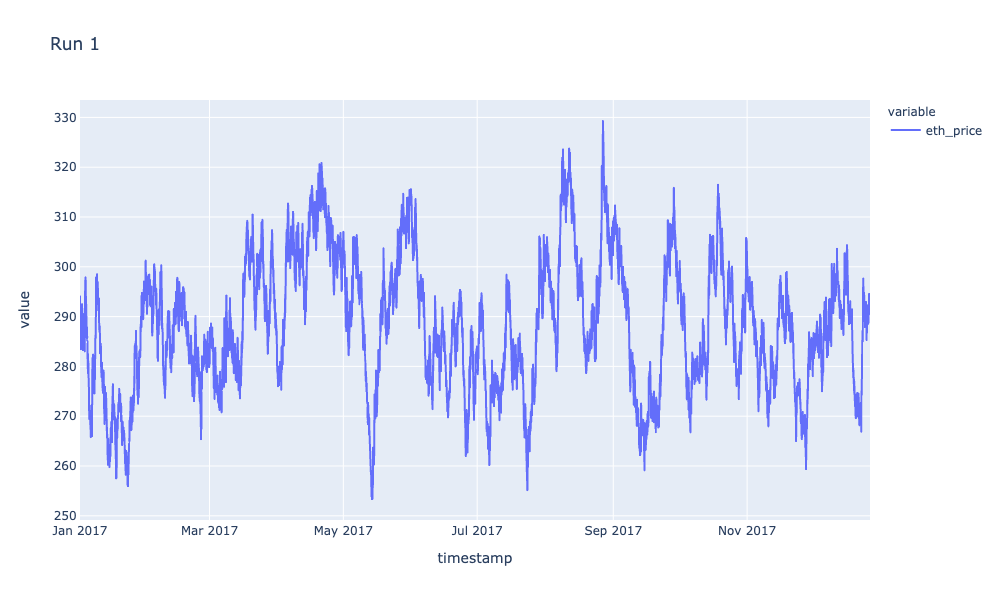

NameError: name 'df_stable_price' is not defined

In [22]:
'''
df.query(f'subset == 0 & run == 1')[['timestamp', 'eth_price', 'run']].plot(
        title=f"Run i ETH",
        x='timestamp',
        y='eth_price', 
        color='run'
)
'''
for i in range(1, 9):
    fig = px.line(
        df.query(f'subset == 0 &run == {i}')[['timestamp', 'eth_price', 'run']],
        title=f"Run {i}",
        x="timestamp",
        y=["eth_price"]
    )
    fig.show()
    fig = px.line(
        df_stable_price.query(f'run == {i}'),
        title=f"Run {i}",
        x="timestamp",
        y=["market_price", "market_price_twap", "target_price"],
        facet_col="kp",
        facet_row="kd",
        facet_col_wrap=2,
        height=1000
    )
    # fig.for_each_annotation(lambda a: a.update(text = f"kp={param_sweep[int(a.text.split('=')[-1])]['kp']} ki={param_sweep[int(a.text.split('=')[-1])]['ki']}"))
    fig.show()
    fig = px.line(
        df_stable_price.query(f'run == {i}'),
        title=f"Run {i} rates",
        x="timestamp",
        y=["apy"],
        facet_col="kp",
        facet_row="kd",
        facet_col_wrap=2,
        height=1000
    )
    # fig.for_each_annotation(lambda a: a.update(text = f"kp={param_sweep[int(a.text.split('=')[-1])]['kp']} ki={param_sweep[int(a.text.split('=')[-1])]['ki']}"))
    fig.show()

In [ ]:
fig = px.line(
    df_stable_price, 
    title="Reflexer principal debt",
    x="timestamp", 
    y=["principal_debt"], 
    color='run', 
    facet_col="subset", 
    facet_col_wrap=5,
    height=1000
)
fig.show()

In [ ]:
fig = px.line(
    df_stable_price, 
    title="Secondary market RAI balance",
    x="timestamp", 
    y=["RAI_balance"], 
    color='run', 
    facet_col="subset", 
    facet_col_wrap=5,
    height=1000
)
fig.show()

In [ ]:
fig = px.line(
    df_stable_price, 
    title="Reflexer ETH collateral",
    x="timestamp", 
    y=["eth_collateral"], 
    color='run', 
    facet_col="subset", 
    facet_col_wrap=5,
    height=1000
)
fig.show()

In [ ]:
fig = px.line(
    df_stable_price, 
    title="Secondary market ETH balance",
    x="timestamp", 
    y=["ETH_balance"], 
    color='run', 
    facet_col="subset", 
    facet_col_wrap=5,
    height=1000
)
fig.show()

In [ ]:
df_stable_price.plot(
    x='timestamp', 
    y=['collateralization_ratio'], 
    title='Collateralization ratio', 
    facet_col="subset",
    facet_col_wrap=5,
    height=1000
)